<a href="https://colab.research.google.com/github/ChervonenkisBoris/Laboratory-work/blob/lab-work/lab_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа

Баллы за секции:
- *Задание 1* - 10 баллов
- *Задание 2* - 20 баллов
- *Задание 3* - 30 баллов
- **Итого** - 60 баллов

Оценка за лабу $ = \frac{score}{6}$

## Внимание! Attention! Achtung!

**Данная лабораторная работа является блокирующей**, т.е. если лабораторная работа не выполнена, то оценка за курс - неуд.

Лабораторная работа считается выполненной, если **за каждое из заданий получено не менее 2 баллов**.

## Формат сдачи лабораторной работы

Данная лабораторная работа сдается так же, как и проект - заполняете данный ноутбук, отправляете его через GitHub с указанием проверяющего.

**Ассистенты не будут запускать ячейки кода, а смотреть на выведенный результат и код. Если ячейка кода не запущена - балл не ставится, даже при правильно написанном коде.**

***(Комментарии что курс по Python легче чем по C++ учтены)***

>**Примечание**
>
>Данные задания вдохновлены предметом "Введение в анализ данных" 2 курса, по итогу которого идёт отбор на DS-поток. Если вы видите себя в смежных областях, советуем выполнить данную лабораторку по максимуму.

In [131]:
# Всё необходимое для выполнения данной лабораторной работы!
import requests
from time import sleep

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Задание 1. Парсинг - 10 баллов

В этом задании Вам предстоит работать с API сайта <a target="_blank" href="hh.ru">hh.ru</a>. Документация доступна по <a target="_blank" href="https://github.com/hhru/api/blob/master/docs/vacancies.md#search">ссылке</a>.

<b><font color="red">Внимание!</font> При работе с API не забывайте делать паузы между запросами, иначе вас забанят. Просрочка дедлайна по этой причине не принимается!</b>

**Задача:**
1. выбрать 5 интересующих вас профессий (не смежных, т.е. Аналатик и Data Engineer не считается корректным)
2. затем получить доступные по данным профессиям вакансии в Москве и выделить их физические координаты
3. нанести полученные координаты на карту местоположения компаний

*Пример запроса для профессии:*

In [132]:
URL = 'https://api.hh.ru/vacancies'

params = {
    'text': "Физик-ядерщик",
    'area': 1,
    'page': 0,
    'per_page': 10
}

data = requests.get(URL, params).json()

Если Ваш запрос прошел успешно, то вы получите следующие ключи (значения данных ключей вы найдете по ссылке на документацию):

In [133]:
data.keys()

dict_keys(['items', 'found', 'pages', 'page', 'per_page', 'clusters', 'arguments', 'fixes', 'suggests', 'alternate_url'])

>**Примечание**
>
>В `data['pages']` будет хранится количество найденных страниц вакансий - для корректного сбора данных Вам нужно пробежать по **КАЖДОЙ** странице и сделать соотвествующие запросы.

>**Совет**
>
>Посмотрите что хранится в `items`!

(1 балл) Выберете для нас 5 наиболее интересных специальностей и получите по ним имеющиеся вакансии:

In [134]:
URL = 'https://api.hh.ru/vacancies'

jobs: list[str] = ['Программист', 'Врач', 'Водитель', 'Спасатель', 'Строитель']

vacancies = dict()

for job in jobs:
  params = {
    'text': job,
    'area': 1,
    'page': 0,
    'per_page': 10
  }

  data = requests.get(URL, params).json()
  vacancies[job] = data

  sleep(1)

(1 балл) Посчитайте сколько всего найдено вакансий:

In [135]:
for job in jobs:
  print(f"По профессии {job} найдено {vacancies[job]['found']} вакансий")

print()
print(f"Всего найдено {sum([vacancies[job]['found'] for job in jobs])} вакансий")

По профессии Программист найдено 8649 вакансий
По профессии Врач найдено 4813 вакансий
По профессии Водитель найдено 5882 вакансий
По профессии Спасатель найдено 52 вакансий
По профессии Строитель найдено 1164 вакансий

Всего найдено 20560 вакансий


(1 балл) Создайте структуру данных, которая будет хранить в себе имя компании и ее координаты (широта и долгота):

In [136]:
class Company:
  def __init__(self, name: str, latitude: float, longitude: float):
    self.name = name
    self.latitude = latitude
    self.longitude = longitude

  def __eq__(self, other):
      return self.name == other.name and self.latitude == other.latitude and self.longitude == other.longitude

  def __hash__(self):
        return hash((self.name, self.latitude, self.longitude))

(1 балл) Создайте экземпляр этой структуры данных для каждой компании, которая выставила вакансию:

In [137]:
class Coordinates:
  def __init__(self, latitude: float, longitude: float):
    self.latitude = latitude
    self.longitude = longitude

In [138]:
companies: set[Company] = set()
vacancy_coords_list: list[Coordinates] = []

for job in jobs:
  for page in range(min(vacancies[job]['pages'], 20)):
    params = {
    'text': job,
    'area': 1,
    'page': page,
    'per_page': 10
    }

    data = requests.get(URL, params).json()

    for item in data['items']:
      lat, lng = None, None
      if item['address'] is not None:
        lat, lng = item['address']['lat'], item['address']['lng']
      companies.add(Company(item['name'], lat, lng))
      if lat is not None and lng is not None:
        vacancy_coords_list.append(Coordinates(lat, lng))

    sleep(1)

vacancy_coords = pd.Series(vacancy_coords_list)

print(f'Всего найдено {len(companies)} компаний')

Всего найдено 783 компаний


(1 балл) Найдите количество вакансий, у которых заданы координаты (значения данных может быть пустым):

In [139]:
print(f'Заданы координаты у {vacancy_coords.shape[0]} вакансий')

Заданы координаты у 486 вакансий


(1 балл) Отберите вакансии, которые расположены в пределах МКАД (можно грубо):

In [140]:
moscow_center_coords = (55.7522200, 37.6155600)
lat_coef = 11119
lng_coef = 6258

moscow_vacancies_coords_list: list[Coordinates] = []

def in_moscow(coords: Coordinates) -> bool:
  return (((coords.latitude - moscow_center_coords[0]) * lat_coef) ** 2 + ((coords.longitude - moscow_center_coords[1]) * lng_coef) ** 2) ** 0.5 < 20000

for coords in vacancy_coords:
  if in_moscow(coords):
    moscow_vacancies_coords_list.append(coords)

moscow_vacancies_coords = pd.Series(moscow_vacancies_coords_list)

(1 балл) Постройте график в координатах "широта-долгота" для отображения вакансий внутри МКАД (не забывайте прописать прозрачность, чтобы увидеть скопления):

In [141]:
# your code here

(1 балл) Нанесите все точки вакансий на карту (для этого вам поможет данная <a target="_blank" href="https://plotly.com/python/mapbox-layers/">документации</a>, не забудьте про прозрачность и центрирование по Москве):

In [142]:
# your code here

(2 балла) **Сделайте выводы о проделанной работе:**

>*Подсказки для маленьких: Что вы можете сказать про районы Москвы? Что вы можете сказать про зарплаты? Что вы можете сказать про спрос?*

Ваши выводы здесь :)

## Задание 2. Анализ данных - 20 баллов

Вам предстоит проанализировать датасет, содержащий информацию об бриллианта, их стоимости и остальных характеристиках.



Поясним значения хранящиеся в колонках:
*   `cut` - огранка бриллианта (относится к одной из примерно 10 наиболее распространенных)
*   `color` - цвет бриллианта, прозрачные бриллианты имеют градацию `D-Z`, "более высокие" буквы - более желтоватые, но часто имеют лучшие значения, поскольку цвет трудно определить один раз в кольце
*   `clarity` - чистота бриллианта, наличие включений (внутренних дефектов), чем меньше и мельче, тем лучше
*   `carat_weight` - масса бриллианта (слабо связана с размером бриллианта, т.к. огранка и качество огранки, как правило, играют большую роль)
*   `cut_quality` - качество ограники по системе оценки GIA Cut
*   `lab` - лаборатория оценивания
*   `meas_length` - длина бриллианта
*   `meas_width` - ширина бриллианта
*   `meas_depth` - глубина бриллианта
*   `total_sales_price` - цена бриллианта в долларах.
*    **и прочие колонки**

Скачаем данные:

In [143]:
!gdown 10OJ30qlkE-7zK4JuVTDMY3U4nRB4tu_8

Downloading...
From: https://drive.google.com/uc?id=10OJ30qlkE-7zK4JuVTDMY3U4nRB4tu_8
To: /content/diamonds.csv
100% 35.4M/35.4M [00:00<00:00, 74.2MB/s]


Создадим DataFrame:

In [144]:
import pandas as pd

diamonds = pd.read_csv("diamonds.csv")
diamonds

,Unnamed: 0,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,...,meas_depth,girdle_min,girdle_max,fluor_color,fluor_intensity,fancy_color_dominant_color,fancy_color_secondary_color,fancy_color_overtone,fancy_color_intensity,total_sales_price
0,0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.79,M,M,unknown,NaN,unknown,unknown,unknown,unknown,200
1,1,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,...,1.78,STK,STK,unknown,NaN,unknown,unknown,unknown,unknown,200
2,2,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.77,TN,M,unknown,NaN,unknown,unknown,unknown,unknown,200
3,3,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.78,M,STK,unknown,NaN,unknown,unknown,unknown,unknown,200
4,4,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Excellent,unknown,...,1.82,STK,STK,unknown,NaN,unknown,unknown,unknown,unknown,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219698,219699,Round,E,VS1,10.65,Excellent,GIA,Excellent,Excellent,unknown,...,8.66,M,STK,unknown,NaN,unknown,unknown,unknown,unknown,1210692
219699,219700,Radiant,unknown,VS2,5.17,unknown,GIA,Very Good,Very Good,unknown,...,5.71,TK,XTK,unknown,NaN,Green,unknown,NaN,Fancy Light,1292500
219700,219701,Round,E,VS1,18.07,Excellent,GIA,Excellent,Excellent,unknown,...,10.20,TN,M,unknown,NaN,unknown,unknown,unknown,unknown,1315496
219701,219702,Princess,unknown,SI2,0.90,unknown,GIA,Good,Good,unknown,...,3.47,XTN,VTK,unknown,Faint,Red,unknown,unknown,Fancy,1350000


(0.5 балла) Выведете первые 5 строк датасета:

In [145]:
diamonds.head(5)

,Unnamed: 0,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,...,meas_depth,girdle_min,girdle_max,fluor_color,fluor_intensity,fancy_color_dominant_color,fancy_color_secondary_color,fancy_color_overtone,fancy_color_intensity,total_sales_price
0,0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.79,M,M,unknown,NaN,unknown,unknown,unknown,unknown,200
1,1,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,...,1.78,STK,STK,unknown,NaN,unknown,unknown,unknown,unknown,200
2,2,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.77,TN,M,unknown,NaN,unknown,unknown,unknown,unknown,200
3,3,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.78,M,STK,unknown,NaN,unknown,unknown,unknown,unknown,200
4,4,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Excellent,unknown,...,1.82,STK,STK,unknown,NaN,unknown,unknown,unknown,unknown,200


(0.5 балла) Найдите количество бриллиантов всего в данном датасете:

In [146]:
print(f'Всего в датасете {diamonds.shape[0]} бриллиантов')

Всего в датасете 219703 бриллиантов


(0.5 балла) Выведите максимальную и минимальную цену бриллианта в формате `номер - цена`:

In [147]:
min_price = diamonds['total_sales_price'].min()
cheapest_diamond_index = diamonds[diamonds['total_sales_price'] == min_price].index[0]
print(f"Самый дешевый бриллиант:\n{cheapest_diamond_index} - {diamonds.iloc[cheapest_diamond_index]['total_sales_price']}")

print()

max_price = diamonds['total_sales_price'].max()
most_expensive_diamond_index = diamonds[diamonds['total_sales_price'] == max_price].index[0]
print(f"Самый дорогой бриллиант:\n{most_expensive_diamond_index} - {diamonds.iloc[most_expensive_diamond_index]['total_sales_price']}")

Самый дешевый бриллиант:
0 - 200

Самый дорогой бриллиант:
219702 - 1449881


(1 балл) Посчитайте количество пропусков (пропуском считается значение `unknown` или `None`):

In [148]:
columns = diamonds.columns

emptiness = 0

for col in columns:
  emptiness += diamonds[diamonds[col] == 'unknown'].shape[0]
  emptiness += diamonds[col].isnull().sum()

print(f'В таблице {emptiness} пропусков')

В таблице 1891168 пропусков


(1 балл) Найдите в каких столбцах присутствуют пропуски:

In [149]:
columns_with_emptiness = []

for col in columns:
  if diamonds[diamonds[col] == 'unknown'].shape[0] > 0 or diamonds[col].isnull().sum() > 0:
    columns_with_emptiness.append(col)

print('Пропуски присутствуют в следующих столбцах:')
for col in columns_with_emptiness:
  print(col)

Пропуски присутствуют в следующих столбцах:
color
cut_quality
eye_clean
culet_size
culet_condition
girdle_min
girdle_max
fluor_color
fluor_intensity
fancy_color_dominant_color
fancy_color_secondary_color
fancy_color_overtone
fancy_color_intensity


В нашем датасете присутствуют колонки, которые начинаются с `fancy_color_` или `fluor_`. Большинство значений в этих колонках - `unknown` или `None`, поэтому мы считаем их малоинформативными.

Ваша задача:

1. (0.5 балла) найти количество таких колонок, которые начинаются с `fancy_color_` или `fluor_`:

In [150]:
uninformative_columns = [col for col in columns if col.startswith('fancy_color_') or col.startswith('fluor_')]

print(f'В таблице {len(uninformative_columns)} малоинформативных столбцов:')
print(*uninformative_columns, sep='\n')

В таблице 6 малоинформативных столбцов:
fluor_color
fluor_intensity
fancy_color_dominant_color
fancy_color_secondary_color
fancy_color_overtone
fancy_color_intensity


2. (0.5 балла) найти количество информативных (не `None` или `unknown`) значений в этих колонках:

In [151]:
info_values_sum = 0

print('Количество информативных значений по столбцам:')

for col in uninformative_columns:
  info_values = diamonds[col].shape[0] - diamonds[diamonds[col] == 'unknown'].shape[0] - diamonds[col].isnull().sum()
  print(f'{col} - {info_values}')
  info_values_sum += info_values

print()
print(f'Суммарно этих столбцах {info_values_sum} информативных значений')

Количество информативных значений по столбцам:
fluor_color - 15726
fluor_intensity - 76084
fancy_color_dominant_color - 9164
fancy_color_secondary_color - 1062
fancy_color_overtone - 388
fancy_color_intensity - 9162

Суммарно этих столбцах 111586 информативных значений


3. (0.5 балла) удалить данные колонки из датасета, сохранив изменения (в дальнейшем работаем измененным датасетом):

In [152]:
diamonds = diamonds.drop(columns = uninformative_columns)

diamonds

,Unnamed: 0,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,culet_size,culet_condition,depth_percent,table_percent,meas_length,meas_width,meas_depth,girdle_min,girdle_max,total_sales_price
0,0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,N,unknown,62.7,59.0,2.85,2.87,1.79,M,M,200
1,1,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,N,unknown,61.9,59.0,2.84,2.89,1.78,STK,STK,200
2,2,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,unknown,unknown,61.1,59.0,2.88,2.90,1.77,TN,M,200
3,3,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,unknown,unknown,62.0,59.0,2.86,2.88,1.78,M,STK,200
4,4,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Excellent,unknown,N,unknown,64.9,58.5,2.79,2.83,1.82,STK,STK,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219698,219699,Round,E,VS1,10.65,Excellent,GIA,Excellent,Excellent,unknown,N,unknown,61.3,58.0,14.06,14.18,8.66,M,STK,1210692
219699,219700,Radiant,unknown,VS2,5.17,unknown,GIA,Very Good,Very Good,unknown,unknown,unknown,64.8,65.0,11.55,8.81,5.71,TK,XTK,1292500
219700,219701,Round,E,VS1,18.07,Excellent,GIA,Excellent,Excellent,unknown,N,unknown,60.2,59.0,17.06,17.10,10.20,TN,M,1315496
219701,219702,Princess,unknown,SI2,0.90,unknown,GIA,Good,Good,unknown,N,unknown,70.8,72.0,5.22,4.90,3.47,XTN,VTK,1350000


(1 балл) Проделайте тоже самое для колонок, начинающихся с `culet_`:

In [153]:
other_uninformative_columns = [col for col in columns if col.startswith('culet_')]

print(f'В таблице {len(other_uninformative_columns)} других малоинформативных столбцов:')
print(*other_uninformative_columns, sep='\n')

В таблице 2 других малоинформативных столбцов:
culet_size
culet_condition


In [154]:
info_values_sum = 0

print('Количество информативных значений по столбцам:')

for col in other_uninformative_columns:
  info_values = diamonds[col].shape[0] - diamonds[diamonds[col] == 'unknown'].shape[0] - diamonds[col].isnull().sum()
  print(f'{col} - {info_values}')
  info_values_sum += info_values

print()
print(f'Суммарно этих столбцах {info_values_sum} информативных значений')

Количество информативных значений по столбцам:
culet_size - 133963
culet_condition - 15319

Суммарно этих столбцах 149282 информативных значений


In [155]:
diamonds = diamonds.drop(columns = other_uninformative_columns)

diamonds

,Unnamed: 0,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,depth_percent,table_percent,meas_length,meas_width,meas_depth,girdle_min,girdle_max,total_sales_price
0,0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,62.7,59.0,2.85,2.87,1.79,M,M,200
1,1,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,61.9,59.0,2.84,2.89,1.78,STK,STK,200
2,2,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,61.1,59.0,2.88,2.90,1.77,TN,M,200
3,3,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,62.0,59.0,2.86,2.88,1.78,M,STK,200
4,4,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Excellent,unknown,64.9,58.5,2.79,2.83,1.82,STK,STK,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219698,219699,Round,E,VS1,10.65,Excellent,GIA,Excellent,Excellent,unknown,61.3,58.0,14.06,14.18,8.66,M,STK,1210692
219699,219700,Radiant,unknown,VS2,5.17,unknown,GIA,Very Good,Very Good,unknown,64.8,65.0,11.55,8.81,5.71,TK,XTK,1292500
219700,219701,Round,E,VS1,18.07,Excellent,GIA,Excellent,Excellent,unknown,60.2,59.0,17.06,17.10,10.20,TN,M,1315496
219701,219702,Princess,unknown,SI2,0.90,unknown,GIA,Good,Good,unknown,70.8,72.0,5.22,4.90,3.47,XTN,VTK,1350000


(1 балл) Посчитайте сколько бы стоил (в тысячах долларов) сейф, в котором хранились бы все бриллианты из датасета:

In [156]:
print(f"Такой сейф стоил бы {diamonds['total_sales_price'].sum() / 1000} тысяч долларов")

Такой сейф стоил бы 1517721.991 тысяч долларов


Немного необоснованных манипуляций.

(1 балл) Выберите из датасета строки с четными индексами и выведете значения (не меняя нумерацию индексов):

In [157]:
diamonds[diamonds.index % 2 == 0]

,Unnamed: 0,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,depth_percent,table_percent,meas_length,meas_width,meas_depth,girdle_min,girdle_max,total_sales_price
0,0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,62.7,59.0,2.85,2.87,1.79,M,M,200
2,2,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,61.1,59.0,2.88,2.90,1.77,TN,M,200
4,4,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Excellent,unknown,64.9,58.5,2.79,2.83,1.82,STK,STK,200
6,6,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,64.0,57.0,2.85,2.88,1.84,STK,STK,200
8,8,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,63.5,59.5,2.89,2.92,1.85,STK,TK,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219694,219695,Round,D,IF,12.52,Excellent,HRD,Excellent,Excellent,unknown,62.1,58.0,14.84,14.91,9.24,unknown,unknown,1121792
219696,219697,Oval,H,VS2,18.88,unknown,GIA,Excellent,Excellent,unknown,57.1,55.0,21.34,15.23,8.69,TN,STK,1132347
219698,219699,Round,E,VS1,10.65,Excellent,GIA,Excellent,Excellent,unknown,61.3,58.0,14.06,14.18,8.66,M,STK,1210692
219700,219701,Round,E,VS1,18.07,Excellent,GIA,Excellent,Excellent,unknown,60.2,59.0,17.06,17.10,10.20,TN,M,1315496


(0.5 балла) А теперь с индексами, кратными 6:

In [158]:
diamonds[diamonds.index % 6 == 0]

,Unnamed: 0,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,depth_percent,table_percent,meas_length,meas_width,meas_depth,girdle_min,girdle_max,total_sales_price
0,0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,62.7,59.0,2.85,2.87,1.79,M,M,200
6,6,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,64.0,57.0,2.85,2.88,1.84,STK,STK,200
12,12,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,61.8,58.5,2.85,2.89,1.77,STK,TK,200
18,18,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,61.0,60.0,2.91,2.92,1.78,M,M,200
24,24,Round,L,I1,0.34,Excellent,IGI,Excellent,Excellent,unknown,0.0,0.0,0.00,0.00,0.00,unknown,unknown,204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219678,219679,Round,G,VS1,10.23,Excellent,GIA,Excellent,Excellent,unknown,62.7,55.0,13.82,13.92,8.69,TN,M,859320
219684,219685,Radiant,unknown,I1,0.89,unknown,GIA,Good,Good,unknown,63.8,57.0,6.44,4.96,3.16,TK,VTK,982560
219690,219691,Round,D,VVS2,10.10,Excellent,GIA,Excellent,Excellent,unknown,59.4,59.0,14.07,14.15,8.39,M,STK,1040739
219696,219697,Oval,H,VS2,18.88,unknown,GIA,Excellent,Excellent,unknown,57.1,55.0,21.34,15.23,8.69,TN,STK,1132347


(1 балл) Выберете из датасета только категорильные признаки и выведете датасет:

In [159]:
diamonds.select_dtypes(exclude=["number", "bool"])

,cut,color,clarity,cut_quality,lab,symmetry,polish,eye_clean,girdle_min,girdle_max
0,Round,E,VVS2,Excellent,IGI,Very Good,Very Good,unknown,M,M
1,Round,E,VVS2,Very Good,IGI,Very Good,Very Good,unknown,STK,STK
2,Round,E,VVS2,Excellent,IGI,Very Good,Very Good,unknown,TN,M
3,Round,E,VVS2,Excellent,IGI,Very Good,Very Good,unknown,M,STK
4,Round,E,VVS2,Very Good,IGI,Very Good,Excellent,unknown,STK,STK
...,...,...,...,...,...,...,...,...,...,...
219698,Round,E,VS1,Excellent,GIA,Excellent,Excellent,unknown,M,STK
219699,Radiant,unknown,VS2,unknown,GIA,Very Good,Very Good,unknown,TK,XTK
219700,Round,E,VS1,Excellent,GIA,Excellent,Excellent,unknown,TN,M
219701,Princess,unknown,SI2,unknown,GIA,Good,Good,unknown,XTN,VTK


>**Примечание**
>
>Данный датасет можно использовать для задания 3 (с использованием `sklearn`)

(0.5 балла) Выберете столбец с данными о цене бриллиантов и домножите его на тот столбец, только транспонированный, и выведите полученную матрицу:

In [160]:
prices = diamonds['total_sales_price']
prices.dot(prices)

158540672665477

### Построение графиков

**Требования к графику:**

1.   График должен быть подписан
2.   Оси должны быть подписаны
3.   Должна быть легенда графика
4.   График должен быть информативным (желательно без сильных выбросов)

**Все надписи на русском языке!**

>**Примечание**
>
>График необходимо строить для очищенных данных - в них не должно быть пропусков по осям, по которым строите график. При этом **не перезатирайте** имеющийся датафрейм!

(2 балла) Постройте график `цвет бриллианта - стоимость`:

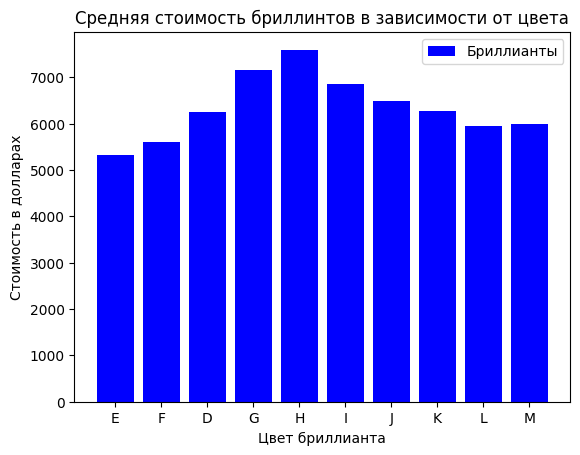

In [161]:
colors = diamonds['color'].value_counts()
colors = colors.drop(index=['unknown'])

prices = pd.Series([diamonds[diamonds['color'] == color]['total_sales_price'].mean() for color in colors.index])

plt.bar(colors.index, prices, color='blue')
plt.xlabel("Цвет бриллианта")
plt.ylabel("Стоимость в долларах")
plt.title("Средняя стоимость бриллинтов в зависимости от цвета")
plt.legend(["Бриллианты"])

plt.show()

(2 балла) Постройте график `лабараторная оценка - кол-во бриллиантов`:

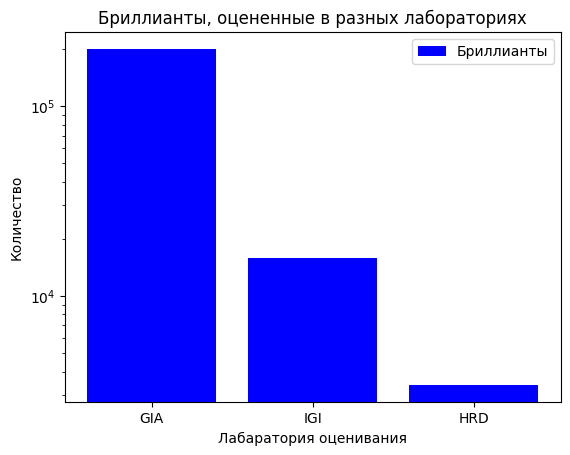

In [162]:
qualities = diamonds['lab'].value_counts()

counts = pd.Series([diamonds[diamonds['lab'] == quality].shape[0] for quality in qualities.index])

plt.bar(qualities.index, counts, color='blue', log=True)
plt.xlabel("Лабаратория оценивания")
plt.ylabel("Количество")
plt.title("Бриллианты, оцененные в разных лабораториях")
plt.legend(["Бриллианты"])

plt.show()

(2 балла) Постройте график `вес бриллианта - стоимость`:

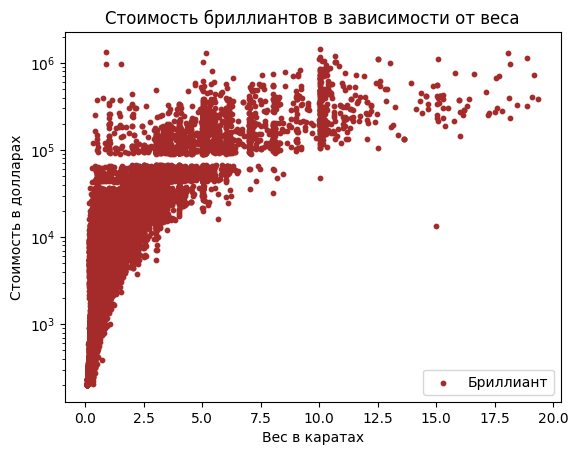

In [163]:
figure, axes = plt.subplots(nrows = 1, ncols = 1)
axes.set_yscale('log')

axes.scatter(diamonds['carat_weight'], diamonds['total_sales_price'], s=10, c="brown")
axes.set_xlabel("Вес в каратах")
axes.set_ylabel("Стоимость в долларах")
axes.legend(["Бриллиант"])
axes.set_title("Стоимость бриллиантов в зависимости от веса")

figure.show()

(2 балла) Постройте график `система оценки GIA Cut - кол-во бриллиантов`:

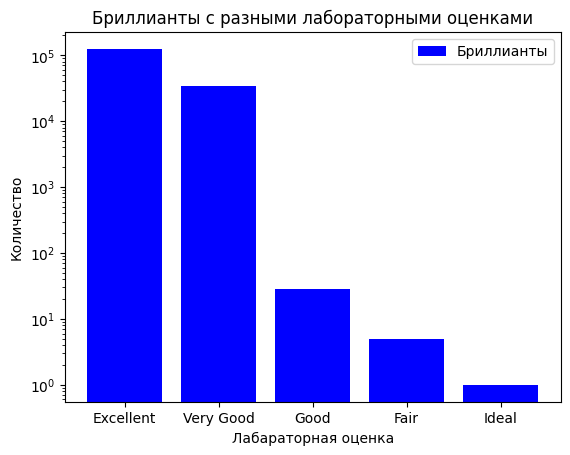

In [164]:
qualities = diamonds['cut_quality'].value_counts()
qualities = qualities.drop(index=['unknown'])

counts = pd.Series([diamonds[diamonds['cut_quality'] == quality].shape[0] for quality in qualities.index])

plt.bar(qualities.index, counts, color='blue', log=True)
plt.xlabel("Лабараторная оценка")
plt.ylabel("Количество")
plt.title("Бриллианты с разными лабораторными оценками")
plt.legend(["Бриллианты"])

plt.show()

(2 балла) **Сделайте выводы по построенным графикам:**

>*Подсказка для маленьких: Что вы можете сказать о графиках полученных выше для данного датасета?*

Судя по первой гистограмме, различия в стоимости бриллиантов разных цветов невелики.

Вторая гистограмма показывает значительные различия в популярности лабораторий GIA, IGI и HRD. GIA - самая популярная, а HRD - самая непопулярная.

График демонстрирует , что есть некая стоимость (в районе 10000 долларов), до которой ее зависимость от веса очевидна, и практически все бриллианты довольно легкие (в пределах 5 карат). А вот у самых дорогих бриллиантов стоимость и вес связаны несильно.

Судя по третьей гистограмме, большинство бриллиантов получили оценки "Excellent" и "Very Good".

## Задание 3. Модель - 30 баллов

В данном задании вам предстоит построить классифицирующую модель размер алмаза и его стоимости, а затем оценить полученную модель.

>**Примечание**
>
>Данная модель не претендует на самый верный индикатор стоимости алмаза, ведь мы не учитываем ничего больше чем стоимость алмаза. Исключительно для образовательных целей :)

Для построения модели нам понадобится 4 столбца, а именно:
- `meas_length`
- `meas_width`
- `meas_depth`
- `total_sales_price`

От остальных столбцов можно избавиться.

(1 балл) Создайте новый датасет и выведите его первые 10 строк:

In [165]:
diamonds_new = diamonds[['meas_length', 'meas_width', 'meas_depth', 'total_sales_price']]

diamonds_new.head(10)

,meas_length,meas_width,meas_depth,total_sales_price
0,2.85,2.87,1.79,200
1,2.84,2.89,1.78,200
2,2.88,2.90,1.77,200
3,2.86,2.88,1.78,200
4,2.79,2.83,1.82,200
5,2.95,2.99,1.81,200
6,2.85,2.88,1.84,200
7,2.86,2.89,1.78,200
8,2.89,2.92,1.85,200
9,2.83,2.87,1.80,200


(1 балл) Перемешайте строки в датафрейме случайным образом:

In [166]:
diamonds_new.sample(frac=1)

,meas_length,meas_width,meas_depth,total_sales_price
187779,6.14,6.23,4.02,9199
46641,4.37,4.40,2.67,902
160547,6.12,7.04,3.60,4770
11697,4.28,4.31,2.69,648
118784,6.60,4.48,2.63,2358
...,...,...,...,...
79602,4.43,4.45,2.77,1152
207780,6.80,6.52,4.95,19910
82689,4.60,4.62,2.73,1196
158887,5.08,5.12,3.08,4352


(1 балл) Сформируем новую колонку - для каждого бриллианта найдем сумму Минковского (p=3) по 3 измерениям бриллианта:

In [167]:
diamonds_new['sum'] = diamonds_new['meas_length'] + diamonds_new['meas_width'] + diamonds_new['meas_depth']

diamonds_new = diamonds_new[diamonds_new['sum'] != 0]

diamonds_new

<ipython-input-167-1b5480a84619>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diamonds_new['sum'] = diamonds_new['meas_length'] + diamonds_new['meas_width'] + diamonds_new['meas_depth']


,meas_length,meas_width,meas_depth,total_sales_price,sum
0,2.85,2.87,1.79,200,7.51
1,2.84,2.89,1.78,200,7.51
2,2.88,2.90,1.77,200,7.55
3,2.86,2.88,1.78,200,7.52
4,2.79,2.83,1.82,200,7.44
...,...,...,...,...,...
219698,14.06,14.18,8.66,1210692,36.90
219699,11.55,8.81,5.71,1292500,26.07
219700,17.06,17.10,10.20,1315496,44.36
219701,5.22,4.90,3.47,1350000,13.59


(1 балл) Сформируем новый датасет из двух колонок - сумма Минковского и `total_sales_price`:

In [168]:
data = diamonds_new[['sum', 'total_sales_price']]

data

,sum,total_sales_price
0,7.51,200
1,7.51,200
2,7.55,200
3,7.52,200
4,7.44,200
...,...,...
219698,36.90,1210692
219699,26.07,1292500
219700,44.36,1315496
219701,13.59,1350000


In [169]:
import sklearn as skl
from sklearn.model_selection import train_test_split

(1 балл) Разделите вашу выборку на две части в соотношении 8:2 - одна выборка будет для тренировка, а другая для тестов вашей модели:

In [170]:
X_train, X_test, y_train, y_test = train_test_split(data['sum'], data['total_sales_price'], test_size=0.2)

# Хоть X - с большой буквы, это лишь один столбец

(2 балла) Постройте график зависимости стоимости от вашего нового параметра размера для тренинг-выборки:

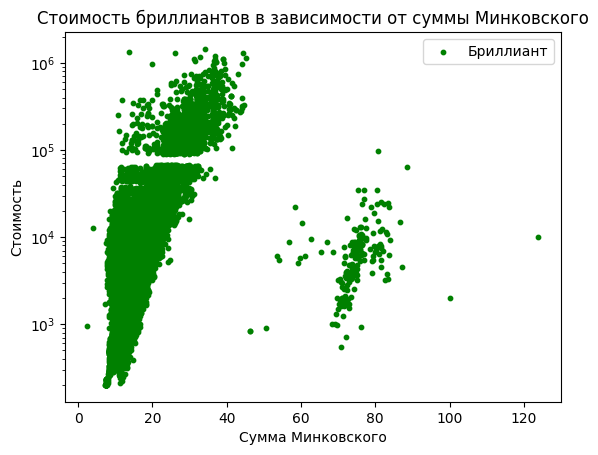

In [171]:
figure, axes = plt.subplots(nrows = 1, ncols = 1)
axes.set_yscale('log')

axes.scatter(X_train, y_train, s=10, c="green")
axes.set_xlabel("Сумма Минковского")
axes.set_ylabel("Стоимость")
axes.legend(["Бриллиант"])
axes.set_title("Стоимость бриллиантов в зависимости от суммы Минковского")

figure.show()

(2 балла) Нанесите на тот же график тестовую выборку, используя другой цвет (не забудьте про параметр прозрачности):

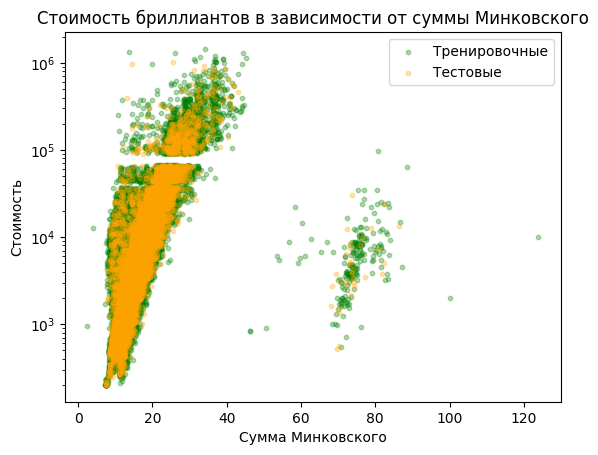

In [172]:
figure, axes = plt.subplots(nrows = 1, ncols = 1)
axes.set_yscale('log')

axes.scatter(X_train, y_train, s=10, c="green", alpha=0.3)
axes.scatter(X_test, y_test, s=10, c="orange", alpha=0.3)
axes.set_xlabel("Сумма Минковского")
axes.set_ylabel("Стоимость")
axes.legend(["Тренировочные", "Тестовые"])
axes.set_title("Стоимость бриллиантов в зависимости от суммы Минковского")

figure.show()

(3 балла) Найдите для каждой бриллианта из тестовой выборки его "ближайшего соседа" из тренинг-выборки. Для каждого бриллианта из тестовой выборки найдите расстояния до соответствующего ближайшего соседа:

In [173]:
# your code here

(3 балла) Найдите насколько сильно (в процентах) отличается цена бриллиантов из тестовой выборки от их соответствующих ближайших соседей:

In [174]:
# your code here

**Данная модель является выдумкой автора. Не важен коэффициент ошибки, важны ваши шаги для получения коэффициента.**

### Введение в машинное обучение

Теперь давайте познакомимся с таким сильным инструментом как `sklearn`.

Вам необходимо:
1. выбрать 2 категориальных признака
2. на их основе обучить решающее дерево
3. оценить среднеквадратичную ошибку цены бриллианта
4. сделать пп. 1-3 и выбрать ту пару, которая дает лучший результат
5. сделать выводы

(3 балла) Мы работаем с категориальными признаками, для них не понятно что есть "больше" и "меньше". Поэтому нам нужно предварительно закодировать значения наших признаков, с чем нам поможет [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html):

In [175]:
# your code here

(3 балла) Разбейте датасет на обучающую и тестовую выбору. Для этого вам поможет [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html):

In [176]:
# your code here

(3 балла) Затем создайте и обучите вашу модель - [DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html):

In [177]:
# your code here

(3 балла) Оцените ошибку вашей модели при помощи [mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html):

In [178]:
# your code here

(3 балла) **Сделайте выводы какие категориальные признаки лучше:**

*Подсказки для маленьких: Что вы можете сказать о зависимости по вашей выборке признаков? Какой вы можете сделать вывод об готовых инструментах для работы и написанных Вами?*

Ваши выводы здесь :)